# 1 Load Time Series Data

In [1]:
# Setting up packages for data manipulation and machine learning
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl 
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Link to the dataset: 
# https://www.kaggle.com/bulentsiyah/for-simple-exercises-time-series-forecasting

path = "https://raw.githubusercontent.com/flo7up/relataly_data/main/alcohol_sales/BeerWineLiquor.csv"
df = pd.read_csv(path)
df.head()

,date,beer
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822


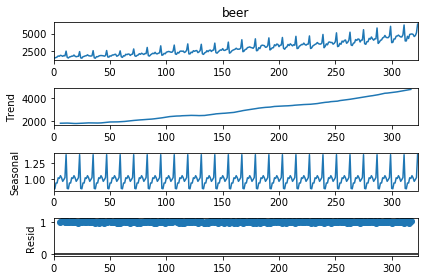

In [2]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['beer'], model='multiplicative', period = 12)
result.plot()
pyplot.show()

# 2 Visualize the Time-Series and check it for Stationarity

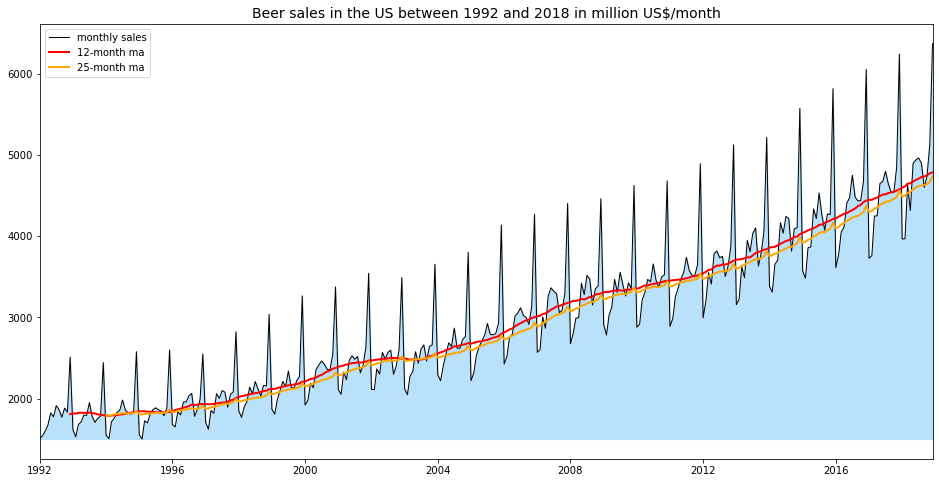

(0.019143247561160443, False)


In [3]:
def check_stationarity(dates, sales, title_string):
    # Visualize the data
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.title(title_string, fontsize=14)
    plt.plot(dates, sales, label='monthly sales', color="black", linewidth=1.0)
    ax.fill_between(dates, sales.min(), sales, color='#b9e1fa')
    ax.set_xlim([dates.min(),dates.max()])
    
    if dates.size > 12:
        ma = sales.rolling(window=12).mean()
        plt.plot(dates, ma, label='12-month ma', color="red", linewidth=2.0)
        ma = sales.rolling(window=25).mean()
        plt.plot(dates, ma, label='25-month ma', color="orange", linewidth=2.0)
    
    plt.legend()
    plt.show()
    
    sales = sales.dropna()
    # Perform an Ad Fuller Test
    # the default alpha = .05 stands for a 95% confidence interval
    adf_test = pm.arima.ADFTest(alpha = 0.05) 
    print(adf_test.should_diff(sales))
    
df_sales = df['beer']
df_dates = pd.to_datetime(df['date']) 
title = "Beer sales in the US between 1992 and 2018 in million US$/month"
check_stationarity(df_dates, df_sales, title)

# 3 Exemplary Differencing and Autocorrelation

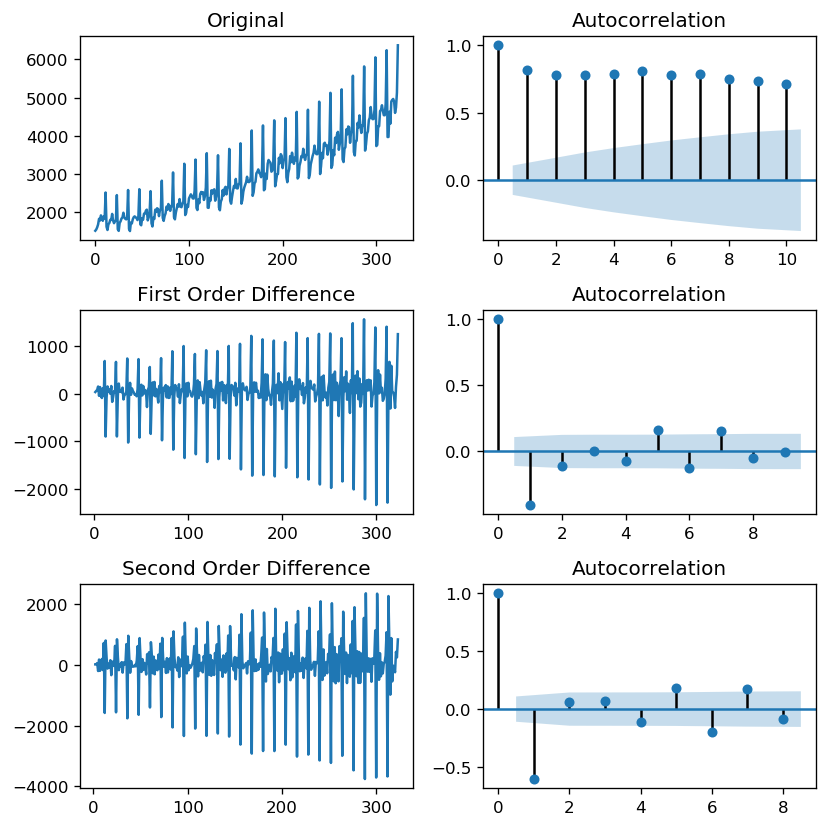

In [13]:
# 3.1 Non-seasonal part
def auto_correlation(df, prefix, lags):
    plt.rcParams.update({'figure.figsize':(7,7), 'figure.dpi':120})
    fig, axes = plt.subplots(3,2, sharex=False)

    # First Difference
    axes[0, 0].plot(df)
    axes[0, 0].set_title('Original' + prefix)
    plot_acf(df_sales, lags=lags, ax=axes[0, 1])

    # First Difference
    df_first_diff = df.diff().dropna()
    axes[1, 0].plot(df_first_diff)
    axes[1, 0].set_title('First Order Difference' + prefix)
    plot_acf(df_first_diff, lags=lags - 1, ax=axes[1, 1])

    # Second Difference
    df_second_diff = df.diff().diff().dropna()
    axes[2, 0].plot(df_second_diff)
    axes[2, 0].set_title('Second Order Difference' + prefix)
    plot_acf(df_second_diff, lags=lags - 2, ax=axes[2, 1])
    plt.tight_layout()
    plt.show()
    
auto_correlation(df_sales, '', 10)

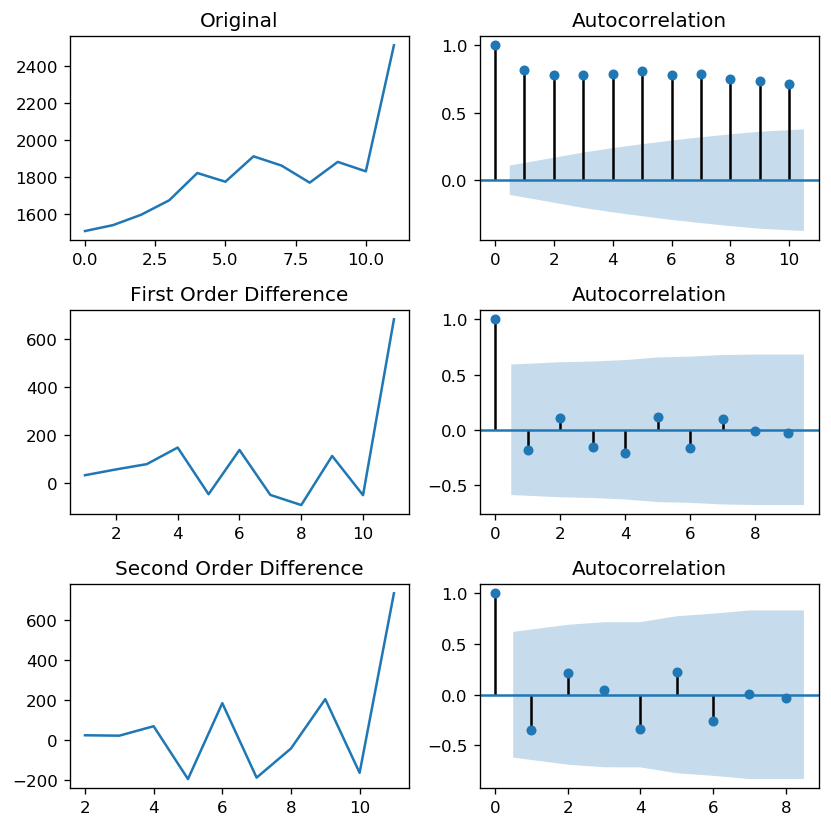

In [8]:
# 3.2 Seasonal part

# Reduce the timeframe to a single seasonal period
df_sales_s = df_sales[0:12]

# Autocorrelation for the seasonal part
auto_correlation(df_sales_s, '', 10)

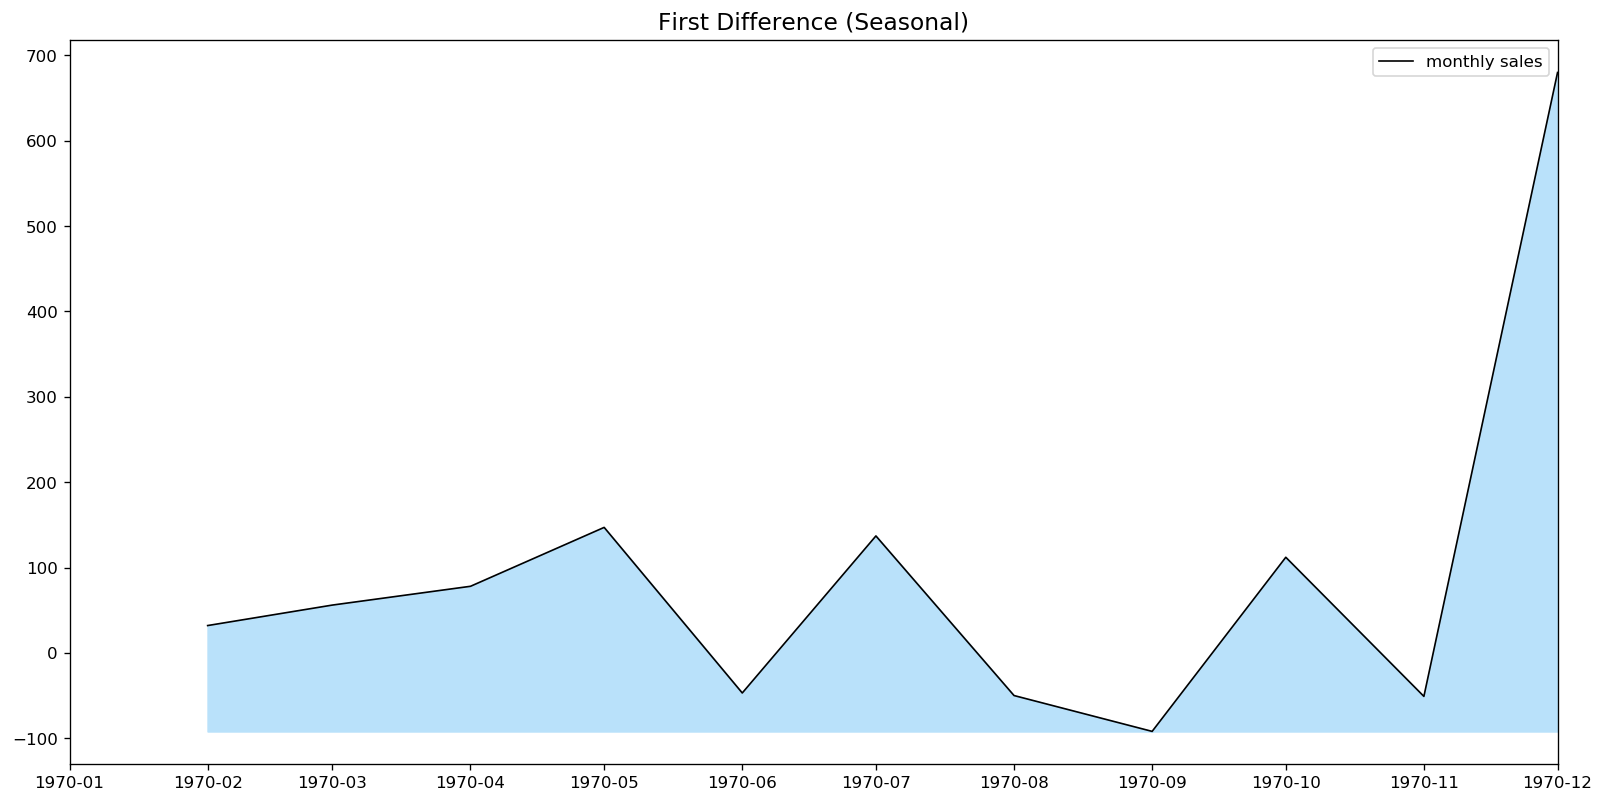

(0.99, True)


In [17]:
# Check if the first difference of the seasonal period is stationary
df_dates_first_s = pd.date_range(df_sales_s.diff().iloc[1], periods=12, freq='MS') 

title = "First Difference (Seasonal)"
check_stationarity(df_dates_first_s, df_sales_s.diff(), title)

# 4 Use Auto-ARIMA to find an Optimal Model

In [18]:
# split into train and test
pred_periods = 30
split_number = df_sales.count() - pred_periods # corresponds to a prediction horizion  of 2,5 years
df_train = df_sales[:split_number]
df_test = df_sales[split_number:]

df_train_dates = df_dates[:split_number]
df_test_dates = df_dates[split_number:] 

# auto_arima
model_fit = pm.auto_arima(df_train, test='adf', 
                         max_p=3, max_d=3, max_q=3, 
                         seasonal=True, m=12,
                         max_P=3, max_D=2, max_Q=3,
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

# summarize the model characteristics
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3383.210, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3351.655, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=3364.350, Time=0.48 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3604.145, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3349.908, Time=0.07 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=3351.532, Time=0.13 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=3353.520, Time=0.54 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=3312.656, Time=0.07 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=3314.483, Time=0.24 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=3314.378, Time=0.13 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=3305.552, Time=0.83 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=3291.425, Time=2.62 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=3306.914, Time=1.95 sec
 ARIMA(2,0,0)(3,1,1)[12]

# 5 Simulate the Time-Series

In [ ]:
# Generate in-sample Predictions
# The parameter dynamic=False means that the model makes predictions upon the lagged values.
# This means that the model is trained until a point in the time-series and then tries to predict the next value.
pred = model_fit.predict_in_sample(dynamic=False) # works only with auto-arima

# Calculate the percentage difference
diff_percent = abs((df_train - pred) / df_train)* 100

# Print the predicted time-series
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("In Sample Sales Prediction", fontsize=14)
plt.plot(df_train_dates, df_train, label='train', color="black", linewidth=1.0)
plt.plot(df_train_dates, pred, label='prediction', color="green", linewidth=1.0)
ax1.fill_between(df_train_dates, 0, df_train, color='#b9e1fa')
ax1.set_ylim([1000, 6500])
ax1.set_xlim([df_train_dates.min(), df_train_dates.max()])
plt.legend()

# Print percentage prediction errors on a separate axis (ax2)
ax2 = ax1.twinx() 
ax2.set_ylabel('Prediction Errors in %', color='tab:purple', fontsize=14)  
ax2.tick_params(axis='y')
ax2.set_yticks(np.arange(0, 50, 5.0))
ax2.set_ylim([0, 50])
ax2.bar(df_train_dates, diff_percent, width=20, color='purple', label='absolute errors')
ax2.set_xlim([df_train_dates[20], df_train_dates.max()])   

plt.show()

# 6 Make Predictions and Visualize them

In [ ]:
# Generate prediction for n periods, 
# Predictions start from the last date of the training data
pred = model_fit.predict(n_periods=pred_periods, dynamic=False)

# Print the predicted time-series
fig, ax = plt.subplots(figsize=(16, 8))
plt.title("Test/Pred Comparison", fontsize=14)
plt.plot(df_train_dates, df_train, label='train', color="black", linewidth=1.0)
plt.plot(df_test_dates, df_test, label='test', color="blue", linewidth=1.0)
plt.plot(df_test_dates, pred, label='forecast', color="green", linewidth=1.0)
ax.fill_between(df_train_dates, 1400, df_train, color='#b9e1fa')
ax.fill_between(df_test_dates, 1400, pred, color='lightgreen')
ax.set_xlim([df_dates[100],df_test_dates.max()])
plt.legend()
plt.show()

# 7 Measure Performance

In [ ]:
# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(df_test, pred)/ df_test))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(df_test, pred)/ df_test)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')